# 시계열수치입력 수치 예측 모델 레시피
시계열 수치를 입력해서 다음 수치를 예측하는 모델들에 대하여 알아보겠다.<br>
각 모델에 코사인(cosine) 데이터를 학습시킨 후 처음 일부 데이터를 알려주면 이후 코사인 형태의 데이터를 얼마나 잘 예측했는지 테스트해보겠다.<br>
<br>
### 1. 데이터셋 준비
먼저 코사인 데이터를 만들어보겠다.<br>
시간의 흐름에 따라 진폭이 -1.0에서 1.0 사이로 변하는 1600개의 실수값을 생성한다.

In [1]:
import numpy as np

signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

생성한 데이터를 확인해보겠다.

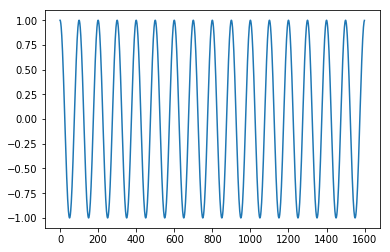

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x,plot_y)
plt.show()

생성한 코사인 데이터를 모델에 학습시키기 위해서는 데이터와 라벨로 구성된 데이터셋으로 만들어야한다.<br>
이전 수치들을 입력하여 다음 수치를 예측하는 문제이므로 **데이터**는 **이전 수치**들이 되고, **라벨**은 **다음 수치**가 된다.<br>
다른 예제들과는 달리 데이터와 라벨이 모두 같은 속성이다.<br>
아래 함수는 시계열 수치를 입력받아 데이터셋을 생성한다.<br>
이 때 look_back 인자는 얼마만큼의 이전 수치를 데이터로 만들것인가를 결정한다.

In [3]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

-1.0에서 1.0까지의 값을 가지는 코사인 데이터를 0.0과 1.0 사이의 값을 가지도록 정규화한 뒤 훈련셋과 시험셋으로 분리한다.<br>
이전 20개의 수치를 입력하여 다음 수치 1개를 예측하는 데이터셋을 만들기 위해 look_back 인자를 40으로 설정한다.<br>
look_back 인자에 따라 모델의 성능이 달라지므로 적정값을 지정하는 것이 중요하다.

In [4]:
from sklearn.preprocessing import MinMaxScaler

look_back = 40

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)


### 2. 레이어 준비(p.255 그림 참고)
- LSTM

Long-Short Term Memeory unit 약자로 순환 신경망 레이어 중 하나이다.<br>

- tanh

활성화 함수로 입력되는 값을 -1과 1 사이의 값으로 출력시킨다.<br>
LSTM의 출력 활성화 함수로 사용된다.<br>
<br>

### 3. 모델 준비
시계열수치를 입력하여 수치를 예측하기 위해 다층퍼셉트론 신경망 모델, 순환신경망 모델, 상태유지 순환신경망 모델, 상태유지 스택 순환신경망 모델을 준비하였다.<br>
<br>
- 다층 퍼셉트론 신경망 모델

Dense 레이어가 4개인 다층퍼셉트론 모델이다.<br>
은닉층에 사용된 Dense 레이어는 32개의 뉴런을 가지고 있고, relu 활성화 함수를 사용했다.<br>
출력층의 Dense 레이어는 하나의 수치값을 예측을 하기 위해서 1개의 뉴런을 가지며, 별도의 활성화 함수를 사용하지 않았다.<br>
과적합을 방지하기 위해 Dropout 레이어가 있다.<br>

    model = Sequential()
    model.add(Dense(32,input_dim=40,activation="relu"))
    model.add(Dropout(0.3))
    for i in range(2):
        model.add(Dense(32,activation="relu"))
        model.add(Dropout(0.3))
    model.add(Dense(1))

- 순환신경망 모델

한 개의 LSTM 레이어을 이용하여 순환신경망 모델을 구성하였다.<br>
출력층은 하나의 수치값을 예측하기 위해 1개 뉴런을 가진 Dense 레이어를 사용하였다.<br>

    model = Sequential()
    model.add(LSTM(32, input_shape=(None, 1)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    
- 상태유지 순환신경망 모델

순환신경망 모델과 동일하나 ‘stateful=True’ 옵션을 사용하여 상태유지 가능한 순환신경망 모델을 구성하였다.<br>
상태유지 모드일 경우 한 배치에서 학습된 상태가 다음 배치 학습 시에 전달되는 방식이다.<br>

    model = Sequential()
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
    model.add(Dropout(0.3))
    model.add(Dense(1))

- 상태유지 스택 순환신경망 모델

상태유지 순환신경망을 여러겹 쌓아올린 모델이다.<br>
층이 하나인 순환신경망에 비해 더 깊은 추론이 가능한 모델이다.<br>

    model = Sequential()
    for i in range(2):
        model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
        model.add(Dropout(0.3))
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
    model.add(Dropout(0.3))
    model.add(Dense(1))

### 4. 전체 소스

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Train on 760 samples, validate on 360 samples
Epoch 1/200





760/760 [==============================] - 3s 4ms/step - loss: 0.1459 - val_loss: 0.0139
Epoch 2/200
760/760 [==============================] - 0s 121us/step - loss: 0.0579 - val_loss: 0.0140
Epoch 3/200
760/760 [==============================] - 0s 122us/step - loss: 0.0422 - val_loss: 0.0212
Epoch 4/200
760/760 [==============================] - 0s 132us/step - loss: 0.0374 - val_loss: 0.0216
Epoch 5/200
760/760 [==============================] - 0s 133us/step - loss: 0.0376 - val_loss: 0.0282
Epoch 6/200
760/760 [==============================] - 0s 106us/step - loss: 0.0381 - val_loss: 0.0206
Epoch 7/200
760/760 [==============================] - 0s 129us/step - loss: 0.0308 - val_loss: 0.0234
Epoch 8/200
760/760 [==============================] - 0s 125us/step - loss: 0.0290 - val_loss: 0.0271
Epoc

760/760 [==============================] - 0s 119us/step - loss: 0.0124 - val_loss: 0.0166
Epoch 51/200
760/760 [==============================] - 0s 114us/step - loss: 0.0133 - val_loss: 0.0156
Epoch 52/200
760/760 [==============================] - 0s 112us/step - loss: 0.0135 - val_loss: 0.0163
Epoch 53/200
760/760 [==============================] - 0s 105us/step - loss: 0.0124 - val_loss: 0.0161
Epoch 54/200
760/760 [==============================] - 0s 125us/step - loss: 0.0137 - val_loss: 0.0176
Epoch 55/200
760/760 [==============================] - 0s 110us/step - loss: 0.0124 - val_loss: 0.0152
Epoch 56/200
760/760 [==============================] - 0s 109us/step - loss: 0.0125 - val_loss: 0.0141
Epoch 57/200
760/760 [==============================] - 0s 129us/step - loss: 0.0122 - val_loss: 0.0175
Epoch 58/200
760/760 [==============================] - 0s 99us/step - loss: 0.0123 - val_loss: 0.0154
Epoch 59/200
760/760 [==============================] - 0s 95us/step - loss: 0

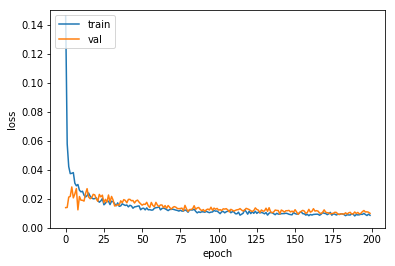

('Train Score: ', 0.009940939680918267)
('Validataion Score: ', 0.009985368740227487)
('Test Score: ', 0.009985368740227487)


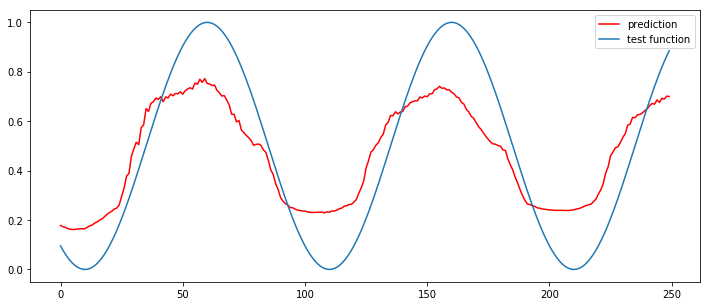

In [1]:
# 다층퍼셉트론 모델

# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train = np.squeeze(x_train) # 차원 축소
x_val = np.squeeze(x_val)
x_test = np.squeeze(x_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(32,input_dim=40,activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adagrad')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
          
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250 # x 축
xhat = x_test[0, None]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])

# 그래프 그리기
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

진폭은 조금 적게 나오지만 주기는 비슷하게 나오는 결과가 나왔다.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 760 samples, validate on 360 samples
Epoch 1/200
760/760 [==============================] - 1s 2ms/step - loss: 0.1701 - val_loss: 0.0433
Epoch 2/200
760/760 [==============================] - 1s 959us/step - loss: 0.0395 - val_loss: 0.0250
Epoch 3/200
760/760 [==============================] - 1s 935us/step - loss: 0.0272 - val_loss: 0.0149
Epoch 4/200
760/760 [==============================] - 1s 933us/step - loss: 0.0184 - val_loss: 0.0085
Epoch 5/200
760/760 [==============================] - 1s 918us/step - loss: 0.0143 - val_loss: 0.0038
Epoch 6/200
760/760 [==============================] - 1s 925us/step - loss: 0.0125 - val_loss: 0.0017
Epoch 7/200
760/760 [==============================] - 1s 933us/step - loss: 0.0091 - val_loss: 9.3729e-04
Epoch 8/200
760/760 [==============================] - 1s 932us/step - loss: 0.0072 - val_loss: 0.0017
Epoch 9/200
760/760 [=============

760/760 [==============================] - 1s 926us/step - loss: 0.0032 - val_loss: 6.1540e-05
Epoch 75/200
760/760 [==============================] - 1s 916us/step - loss: 0.0030 - val_loss: 3.0140e-04
Epoch 76/200
760/760 [==============================] - 1s 919us/step - loss: 0.0031 - val_loss: 5.7305e-05
Epoch 77/200
760/760 [==============================] - 1s 917us/step - loss: 0.0027 - val_loss: 6.4683e-04
Epoch 78/200
760/760 [==============================] - 1s 919us/step - loss: 0.0029 - val_loss: 3.8581e-05
Epoch 79/200
760/760 [==============================] - 1s 922us/step - loss: 0.0028 - val_loss: 6.7750e-05
Epoch 80/200
760/760 [==============================] - 1s 917us/step - loss: 0.0028 - val_loss: 2.1171e-04
Epoch 81/200
760/760 [==============================] - 1s 923us/step - loss: 0.0030 - val_loss: 2.7182e-04
Epoch 82/200
760/760 [==============================] - 1s 963us/step - loss: 0.0030 - val_loss: 7.6261e-05
Epoch 83/200
760/760 [===================

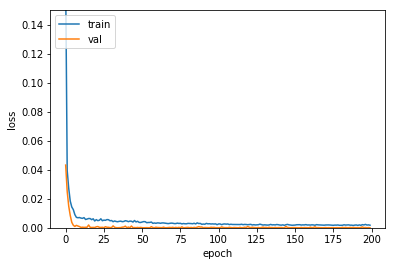

('Train Score: ', 3.176367714140245e-05)
('Validataion Score: ', 3.119279669287304e-05)
('Test Score: ', 3.119279669287304e-05)


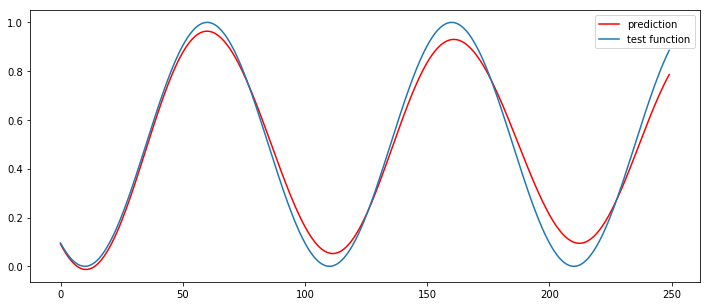

In [2]:
# 순환신경망 모델

# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

초반에는 진폭과 주기가 비슷하게 가지만 후반부로 달라지기 시작한다.

Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 31s 41ms/step - loss: 0.0331 - val_loss: 0.0111
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 30s 40ms/step - loss: 0.0089 - val_loss: 5.5800e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 30s 40ms/step - loss: 0.0053 - val_loss: 0.0011
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 31s 40ms/step - loss: 0.0048 - val_loss: 4.9217e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 30s 39ms/step - loss: 0.0039 - val_loss: 0.0014
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 30s 40ms/step - loss: 0.0041 - val_loss: 8.0565e-05
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 32s 42m

760/760 [==============================] - 24s 31ms/step - loss: 0.0021 - val_loss: 6.9219e-05
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 24s 31ms/step - loss: 0.0019 - val_loss: 2.0787e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 24s 31ms/step - loss: 0.0020 - val_loss: 3.1270e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 24s 32ms/step - loss: 0.0020 - val_loss: 5.5313e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 24s 32ms/step - loss: 0.0021 - val_loss: 1.8173e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 24s 32ms/step - loss: 0.0020 - val_loss: 2.4772e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 24s 31ms/step - loss: 0.0023 - val_loss: 3.9429e-04

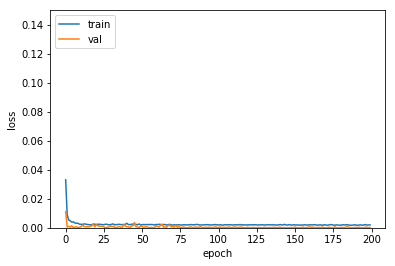

('Train Score: ', 0.00023718151675391135)
('Validataion Score: ', 0.00022581018888179945)
('Test Score: ', 0.00022581018888179945)


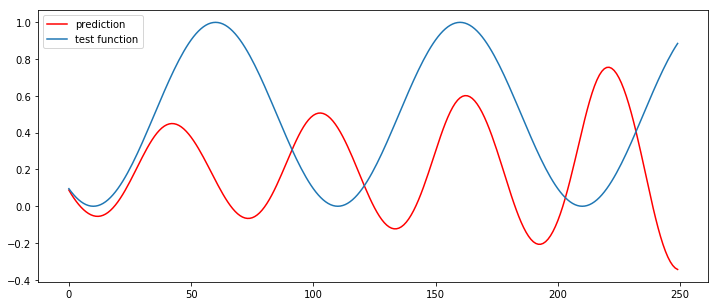

In [3]:
# 상태유지 순환신경망 모델

# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

코사인 곡선의 패턴은 나오지만 동일 에포크와 동일 셀 크기의 순환신경망 모델에 비해 좋지 않은 결과를 얻었다.

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 760 samples, validate on 360 samples
Epoch 1/1





760/760 [==============================] - 74s 98ms/step - loss: 0.0776 - val_loss: 0.0455
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0277 - val_loss: 0.0568
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 72s 95ms/step - loss: 0.0099 - val_loss: 0.0062
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 72s 95ms/step - loss: 0.0088 - val_loss: 0.0109
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 72s 95ms/step - loss: 0.0070 - val_loss: 0.0071
Train on 760 samples, validate on 360 sampl

760/760 [==============================] - 71s 93ms/step - loss: 0.0410 - val_loss: 0.0248
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0075 - val_loss: 0.0092
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0085 - val_loss: 0.0106
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0062 - val_loss: 0.0265
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0065 - val_loss: 0.0043
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0064 - val_loss: 0.0315
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 72s 95ms/step - loss: 0.0088 - val_loss: 0.0312
Train on 760 samples, valid

Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0038 - val_loss: 8.5751e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0034 - val_loss: 0.0020
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0043 - val_loss: 0.0030
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0039 - val_loss: 3.5182e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0025 - val_loss: 0.0014
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 72s 95ms/step - loss: 0.0029 - val_loss: 3.2783e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 72s 95m

Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0025 - val_loss: 6.3452e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0022 - val_loss: 1.3125e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0020 - val_loss: 1.7443e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0023 - val_loss: 0.0018
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0026 - val_loss: 0.0028
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0035 - val_loss: 0.0010
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94m

760/760 [==============================] - 71s 93ms/step - loss: 0.0024 - val_loss: 3.8284e-04
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 93ms/step - loss: 0.0023 - val_loss: 0.0011
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 71s 94ms/step - loss: 0.0024 - val_loss: 6.7236e-04


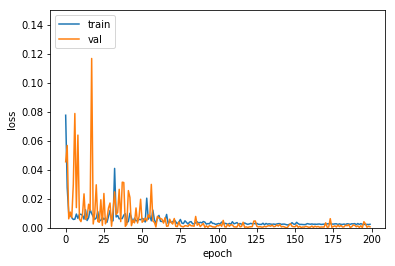

('Train Score: ', 0.0007073837317234696)
('Validataion Score: ', 0.0006724612316757078)
('Test Score: ', 0.0006724612316757078)


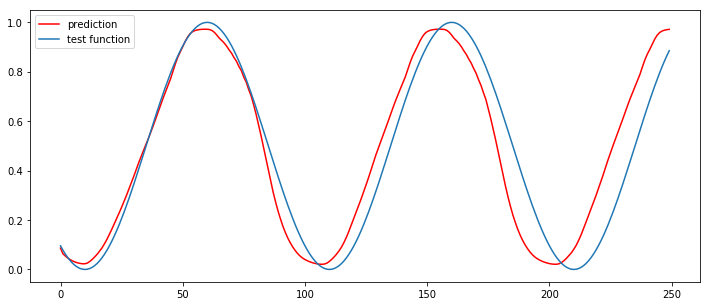

In [1]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

진폭과 주기가 거의 유사한 형태의 결과를 얻었다. 하지만 주기가 약간 앞서 모습이 보인다.<br>